#### Installation
To use [tikzmagic](https://github.com/robjstan/tikzmagic) simply run:  `pip install git+git://github.com/robjstan/tikzmagic.git`

In [1]:
import tikzmagic

### Devito: (Re-)design of the code generation engine

Following the initial `Propagator` a new more flexible approach is required to extend capabilities beyond the current scope. In particular an alternative to the current template-based code generation approach is sought to provide more flexibility when handling sets of expression and loop objects to facilitate more agile manipulation of the code to generate. The particular restrictions of the current implementation we aim to lift are:
* Hard-coded outer time loop - Users my need to define their own (adaptive) time stepping, which needs to be facilitated through pure Python in the first instance, and possibly symbolic expressions in later development.
* Explicit tracking of symbol properties (save, loop limits, padding, orders, etc.) on the Propagator making it extremely complex and hard to extend functionality.
* Limited insertion of "customisation expression", such pre/post loops only before and after the space loops.
* Explicit parameter definition of loop variables on the Propagator, and timestepping on the Operator. 

The below diagram aims to describe the desired abstractions and class structures to enable a detailed discussion before implementing the changes in a _non-agile_ fashion. The core idea is that we need the following three core abstractions to manipulate code programmatically by working on an intermediate represention of Python objects:
* Kernel: Represents a single unit of compilable code; equivalent to Operator/Propapagator.
* Expression: An expression/assignment that works on a set of variables.
* Iteration: A single loop with loop bounds over an iteration space or sub-space

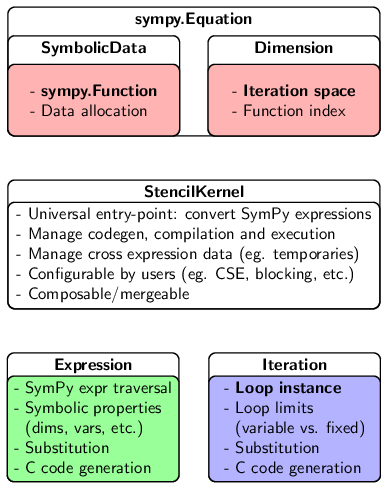

In [2]:
%%tikz -s 0.4

%# Style definitions
\tikzstyle{line} = [draw, thick];
\tikzstyle{arrow} = [-stealth, line];
\tikzstyle{box} = [draw, thick, rectangle, rounded corners, font=\sffamily];
\tikzstyle{symbolic} = [box, minimum height=5ex, minimum width=16ex, fill=red!30]
\tikzstyle{cg-expr} = [box, minimum height=8ex, minimum width=24ex, fill=green!40]
\tikzstyle{cg-iter} = [box, minimum height=8ex, minimum width=24ex, fill=blue!30]

%# Core codegen classes
\node (expression) [box, minimum height=18ex, minimum width=24ex] {};
\node [anchor=north, font=\sffamily\bfseries] at (expression.north)  {Expression};
\node (expr) [cg-expr, anchor=south, align=left] at (expression.south) 
    {- SymPy expr traversal \\
     - Symbolic properties \\\ \ (dims, vars, etc.) \\
     - Substitution \\
     - C code generation};

\node (iteration) [box, minimum height=18ex, minimum width=24ex, right=4ex] at (expression.east) {};
\node [anchor=north, font=\sffamily\bfseries] at (iteration.north)  {Iteration};
\node (iter) [cg-iter, anchor=south, align=left] at (iteration.south) 
    {- {\sffamily\bfseries Loop instance} \\
     - Loop limits \\\ \ (variable vs. fixed) \\
     - Substitution \\
     - C code generation};

\node (kernel) [box, minimum height=18ex, minimum width=52ex, , above=6ex, xshift=2ex] at (expression.north east) {};
\node [anchor=north, font=\sffamily\bfseries] at (kernel.north)  {StencilKernel};
\node (expr) [box, minimum height=14ex, minimum width=52ex, anchor=south, align=left] at (kernel.south) 
    {- Universal entry-point: convert SymPy expressions \\
     - Manage codegen, compilation and execution \\
     - Manage cross expression data (eg. temporaries)\\
     - Configurable by users (eg. CSE, blocking, etc.)\\
     - Composable/mergeable};

%# Symbolic layer
\node (equation) [box, minimum height=18ex, minimum width=52ex, above=6ex] at (kernel.north) {};
\node [anchor=north, font=\sffamily\bfseries] at (equation.north)  {sympy.Equation};

\node (function) [box, minimum height=14ex, minimum width=24ex, anchor=south west] at (equation.south west) {};
\node [anchor=north, font=\sffamily\bfseries] at (function.north)  {SymbolicData};
\node (dim) [symbolic, anchor=south, align=left, minimum width=24ex, minimum height=10ex] at (function.south) 
    {- {\sffamily\bfseries sympy.Function} \\
     - Data allocation};
    
\node (dimension) [box, minimum height=14ex, minimum width=24ex, anchor=south east] at (equation.south east) {};
\node [anchor=north, font=\sffamily\bfseries] at (dimension.north)  {Dimension};
\node (dim) [symbolic, anchor=south, align=left, minimum width=24ex, minimum height=10ex] at (dimension.south) 
    {- {\sffamily\bfseries Iteration space} \\
     - Function index};

The above abstractions exist in the current Devito-master as classes - but they are lacking several key functionalities that the Propagator currently provides (OpenMP pragmas, loop blocking, etc.). However, they do not assume the fixed loop structure that the current Propagator enforces, and they will (hopefully) provide a much cleaner interface that requires minimal user input. Ideally, the loop structure is hereby implicitly derived from the Dimension objects in each expression.

For example, using a familiar source/receiver paradigm, we might want to create the following (pseudo-)code:
```
for (int t = 0; t < 5; ++t):
    for (int p = 0; p < 3; ++p):
        <source_insertion>[t, p]
    for (int x = 0 x < 12; ++x):
        for (int y = 0; y < 14; ++y):
            <stencil>[t, x, y]
    for (int p = 0; p < 3; ++p):
        <rec_interpolation>[t, p]
```

To generate this, all the information we require can be encapsulated in three SymPy expressions:
```
eq_src = Eq(u[t, p_x, p_y], u[t, p_x, p_y] + <src_expr>(src[t, p]))
eq_stencil = Eq(u[t, x, y], <stencil>(u[t, x, y], m[x, y]))
eq_rec = Eq(rec[t, p], <rec_expr>(u[t, p_x, p_y)))
```
Here, the terms `<src_expr>`, `<rec_expr>` and `stencil` are short-hand to denote some expanded SymPy expression that depends on `src[t, p]` or `u[t, x, y]` and `p_x`/`p_y` is shorthand for the derived x, y coordinates of the sparse points (which only depend on `p`, not actually on the `x`/`y` loops). From these we should, conceptually, be able to build the entire kernel with:
```
kernel = StencilKernel([eq_src, eq_stencil, eq_rec])
```
Provided that the order of the equation objects defines the data dependencies between them (ie. first insert the source term into `u`, then update `u` via the stencil and finally extract result from `u`) and assuming that the order of the dimension symbols within the function objects `u`, `m`, `src` and `rec` defines the order of the loop structure, the above **four lines should be sufficient to generate the desired loop nest**. Please also note that no additional parameters need to be passed or set on the kernel object, other than compilation-specific settings.

One of the key criteria for the Expression/Iteration classes is that they compose to yield a "tree", in which each component is able to generate it's corresponding C code and to perform recursive symbol and expression substitution. This way, manipulating the internal loop and expression becomes programmable, allowing us to automate various kernel re-writing techniques. As an example, the loop nest defined above would look like the following diagram:

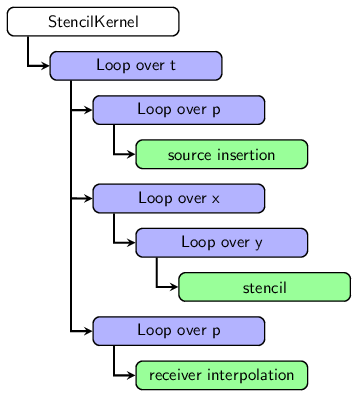

In [3]:
%%tikz -s 0.4

%# Style definitions
\tikzstyle{line} = [draw, very thick];
\tikzstyle{arrow} = [-stealth, line];
\tikzstyle{box} = [draw, thick, rectangle, rounded corners, minimum height=4ex, minimum width=24ex, font=\sffamily];
\tikzstyle{expr} = [box, fill=green!40]
\tikzstyle{iter} = [box, fill=blue!30]

\node (kernel) [box] {StencilKernel};
\node (t-loop) [iter, below=2ex, xshift=6ex] at (kernel.south) {\sf Loop over t};
\node (p1-loop) [iter, below=2ex, xshift=6ex] at (t-loop.south) {\sf Loop over p};
\node (src-expr) [expr, below=2ex, xshift=6ex] at (p1-loop.south) {\sf source insertion};
\node (x-loop) [iter, below=2ex, xshift=-6ex] at (src-expr.south) {\sf Loop over x};
\node (y-loop) [iter, below=2ex, xshift=6ex] at (x-loop.south) {\sf Loop over y};
\node (stencil) [expr, below=2ex, xshift=6ex] at (y-loop.south) {\sf stencil};
\node (p2-loop) [iter, below=2ex, xshift=-12ex] at (stencil.south) {\sf Loop over p};
\node (rec-expr) [expr, below=2ex, xshift=6ex] at (p2-loop.south) {\sf receiver interpolation};

\path [arrow] ([xshift=3ex]kernel.south west) -- +(0,-.62) -- (t-loop.west);
\path [arrow] ([xshift=3ex]t-loop.south west) -- +(0,-.62) -- (p1-loop.west);
\path [arrow] ([xshift=3ex]p1-loop.south west) -- +(0,-.62) -- (src-expr.west);
\path [arrow] ([xshift=3ex]t-loop.south west) -- +(0,-2.49) -- (x-loop.west);
\path [arrow] ([xshift=3ex]x-loop.south west) -- +(0,-.62) -- (y-loop.west);
\path [arrow] ([xshift=3ex]y-loop.south west) -- +(0,-.62) -- (stencil.west);
\path [arrow] ([xshift=3ex]t-loop.south west) -- +(0,-5.3) -- (p2-loop.west);
\path [arrow] ([xshift=3ex]p2-loop.south west) -- +(0,-.62) -- (rec-expr.west);

Using the above tree structure, current functionalities can be implemented as manipulations os Extression/Iteration objects, where for example CSE creates multiple expressions from a single expression, and loop blocking creates additional loops, as shown below:

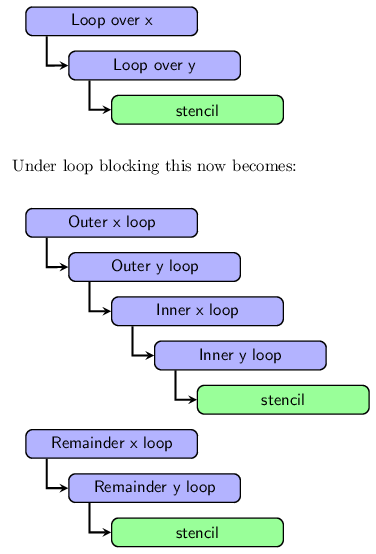

In [4]:
%%tikz -s 0.4

%# Style definitions
\tikzstyle{line} = [draw, very thick];
\tikzstyle{arrow} = [-stealth, line];
\tikzstyle{box} = [draw, thick, rectangle, rounded corners, minimum height=4ex, minimum width=24ex, font=\sffamily];
\tikzstyle{expr} = [box, fill=green!40]
\tikzstyle{iter} = [box, fill=blue!30]

\node (x-loop) [iter, below=2ex, xshift=-6ex] {\sf Loop over x};
\node (y-loop) [iter, below=2ex, xshift=6ex] at (x-loop.south) {\sf Loop over y};
\node (stencil) [expr, below=2ex, xshift=6ex] at (y-loop.south) {\sf stencil};

\path [arrow] ([xshift=3ex]x-loop.south west) -- +(0,-.62) -- (y-loop.west);
\path [arrow] ([xshift=3ex]y-loop.south west) -- +(0,-.62) -- (stencil.west);

\node (comment) [below=4ex, xshift=-6ex] at (stencil.south) {Under loop blocking this now becomes:};

\node (x-outer) [iter, below=24ex] at (x-loop.south) {\sf Outer x loop};
\node (y-outer) [iter, below=2ex, xshift=6ex] at (x-outer.south) {\sf Outer y loop};
\node (x-inner) [iter, below=2ex, xshift=6ex] at (y-outer.south) {\sf Inner x loop};
\node (y-inner) [iter, below=2ex, xshift=6ex] at (x-inner.south) {\sf Inner y loop};
\node (st1) [expr, below=2ex, xshift=6ex] at (y-inner.south) {\sf stencil};
\node (x-rem) [iter, below=2ex, xshift=-24ex] at (st1.south) {\sf Remainder x loop};
\node (y-rem) [iter, below=2ex, xshift=6ex] at (x-rem.south) {\sf Remainder y loop};
\node (st2) [expr, below=2ex, xshift=6ex] at (y-rem.south) {\sf stencil};

\path [arrow] ([xshift=3ex]x-outer.south west) -- +(0,-.62) -- (y-outer.west);
\path [arrow] ([xshift=3ex]y-outer.south west) -- +(0,-.62) -- (x-inner.west);
\path [arrow] ([xshift=3ex]x-inner.south west) -- +(0,-.62) -- (y-inner.west);
\path [arrow] ([xshift=3ex]y-inner.south west) -- +(0,-.62) -- (st1.west);
\path [arrow] ([xshift=3ex]x-rem.south west) -- +(0,-.62) -- (y-rem.west);
\path [arrow] ([xshift=3ex]y-rem.south west) -- +(0,-.62) -- (st2.west);

### Final thoughts
The current re-design only considers "Propagator"-level (indexed, tier 2) expressions at the moment. However, the form of the SymPy expression handed down by the user is only relevant to our internal Expression abstraction, so once this class is capable of "lowering" "Operator"-level (function, tier-1) expression on creation, there is no need to maintain the Operator/Propagator separation. As a results the "StencilKernel" abstraction simply becomes the new Operator in Devito 2.0.